<a href="https://colab.research.google.com/github/01star01ek/01star01ek/blob/main/%EC%B0%90%EA%B9%94%EB%81%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔧 설치 중...
/content
/content/SimSwap
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 68.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 605.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 112.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.0.1+cu118 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 31.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 84.3 MB/

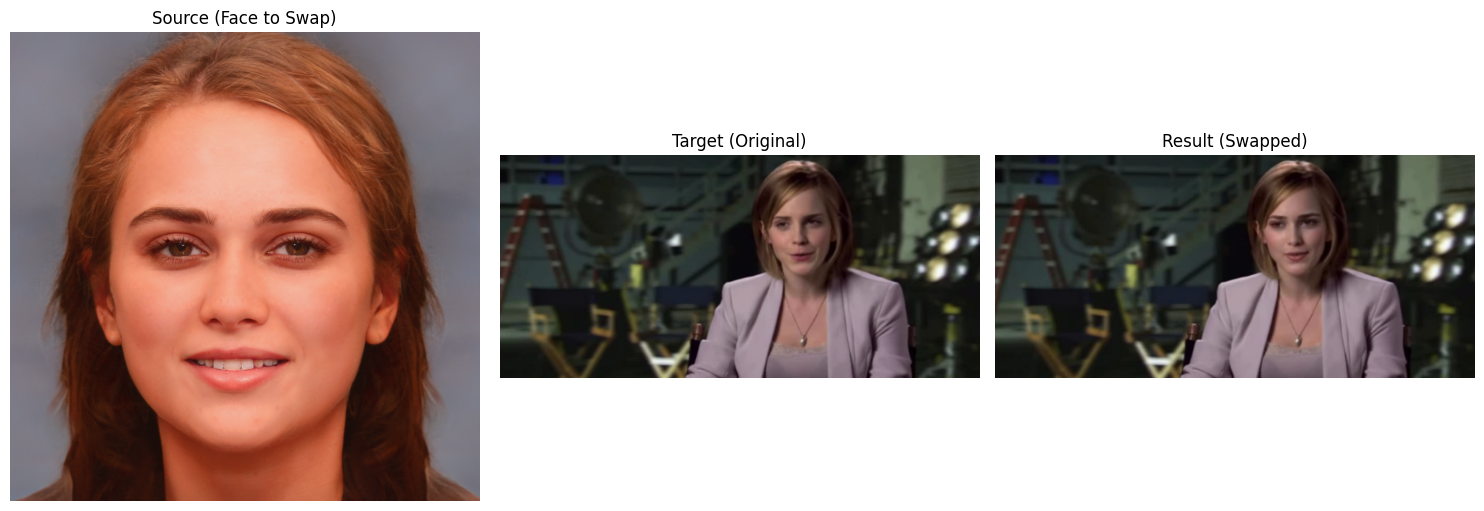

In [1]:
# 설치 및 설정
import os
import shutil
from datetime import datetime
import cv2
import matplotlib.pyplot as plt

# 🔧 SimSwap 설치
print("🔧 설치 중...")
if os.path.exists('/content/SimSwap'):
    shutil.rmtree('/content/SimSwap')

%cd /content
!git clone -q https://github.com/woctezuma/SimSwap.git SimSwap
%cd SimSwap
!git checkout -q upgrade-insightface

# 필요한 라이브러리 설치
!pip install --force-reinstall "numpy<2.0"
!pip install -q torch==2.0.1 torchvision==0.15.2 --index-url https://download.pytorch.org/whl/cu118
!pip install -q insightface==0.7.3 onnxruntime moviepy opencv-python imageio==2.34.0

# 📥 모델 다운로드
print("📥 모델 다운로드...")
!mkdir -p arcface_model parsing_model/checkpoint checkpoints insightface_func/models
!wget -q https://github.com/woctezuma/SimSwap-colab/releases/download/1.0/arcface_checkpoint.tar -O arcface_model/arcface_checkpoint.tar
!wget -q https://github.com/neuralchen/SimSwap/releases/download/1.0/checkpoints.zip -O checkpoints.zip
!wget -q https://github.com/neuralchen/SimSwap/releases/download/1.0/79999_iter.pth -O parsing_model/checkpoint/79999_iter.pth
!wget -q https://github.com/woctezuma/SimSwap-colab/releases/download/antelope/antelope.zip -O antelope.zip

!unzip -q checkpoints.zip -d checkpoints
!unzip -q antelope.zip -d insightface_func/models/

# 🔧 PyTorch 호환성 수정
print("🔧 PyTorch 호환성 수정...")
!sed -i.bak 's/torch.load(netArc_checkpoint, map_location=torch.device("cpu"))/torch.load(netArc_checkpoint, map_location=torch.device("cpu"), weights_only=False)/' models/fs_model.py
!sed -i 's/det_size=(640,640)/det_size=(320,320)/' test_wholeimage_swapsingle.py

# 🔧 탐지 임계값 조정
with open('test_wholeimage_swapsingle.py', 'r') as f:
    content = f.read()

if 'app.models["detection"].nms_thresh' not in content:
    new_lines = []
    for line in content.splitlines():
        new_lines.append(line)
        if 'app.prepare(' in line:
            new_lines.append('    # 탐지 임계값 조정')
            new_lines.append('    if hasattr(app.models, "detection"):')
            new_lines.append('        app.models["detection"].nms_thresh = 0.3')
            new_lines.append('        app.models["detection"].det_thresh = 0.3')
    with open('test_wholeimage_swapsingle.py', 'w') as f:
        f.write('\n'.join(new_lines))

print("✅ 탐지 설정 수정 완료")

# 📂 이미지 경로 설정
input_dir = '/content/input'
source_path = os.path.join(input_dir, 'source.png')
target_path = os.path.join(input_dir, 'target.png')

assert os.path.exists(source_path), f"{source_path} 없음"
assert os.path.exists(target_path), f"{target_path} 없음"

# 📂 결과 폴더 생성
output_dir = f'output/{datetime.now().strftime("%Y%m%d_%H%M%S")}'
os.makedirs(output_dir, exist_ok=True)

# 🧪 실행
!python test_wholeimage_swapsingle.py \
    --crop_size 224 \
    --use_mask \
    --no_simswaplogo \
    --name people \
    --Arc_path arcface_model/arcface_checkpoint.tar \
    --pic_a_path {source_path} \
    --pic_b_path {target_path} \
    --pic_specific_path {target_path} \
    --output_path {output_dir}

# 📸 결과 확인 및 시각화
output_files = [f for f in os.listdir(output_dir) if f.endswith(('.jpg', '.png'))]
print(f"생성된 파일: {output_files}")

if output_files:
    result_img = cv2.imread(os.path.join(output_dir, output_files[0]))
    result_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(source_path), cv2.COLOR_BGR2RGB))
    plt.title('Source (Face to Swap)')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(cv2.imread(target_path), cv2.COLOR_BGR2RGB))
    plt.title('Target (Original)')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(result_rgb)
    plt.title('Result (Swapped)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("❌ 결과 파일이 생성되지 않았습니다.")
